<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Aprendizaje Supervisado -> Grupo 5 Cohorte 2</h1>

Patricia Loto

Sandra Monica Olariaga

Veronica Bornancini

Fernandez María Soledad   


# Diplodatos Kaggle Competition

We present this peace of code to create the baseline for the competition, and as an example of how to deal with these kind of problems. The main goals are that you:

1. Learn
2. Try different models and see which one fits the best the given data
3. Get a higher score than the given one in the current baseline example
4. Try to get the highest score in the class :)

In [1]:
# Importamos las librerías necesarias
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats 
import seaborn as sns 
import warnings

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display_html
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [2]:
# Leemos el dataset original
original_df = pd.read_csv('../data/train.csv')

# 1. Learn

## 1.1 Verificamos columnas con sus datos

In [3]:
# 1) Averiguamos el nombre de cada variable presente en el dataset
original_df.columns

Index(['TripType', 'VisitNumber', 'Weekday', 'Upc', 'ScanCount',
       'DepartmentDescription', 'FinelineNumber'],
      dtype='object')

In [4]:
original_df.shape

(453411, 7)

In [5]:
# 2) Inspeccionamos las primeras filas del dataset
original_df[:5]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,8,9,Friday,1.070081e+09,1,IMPULSE MERCHANDISE,115.0
2,8,9,Friday,3.107000e+03,1,PRODUCE,103.0
3,8,9,Friday,4.011000e+03,1,PRODUCE,5501.0
4,8,10,Friday,6.414410e+09,1,DSD GROCERY,2008.0


**Observaciones:** Contamos con 453.411 registros y 7 variables en nuestra base de datos;
* **TripType:** Es nuestra variable objetivo. Es una identificación categórica (id) que representa el tipo de viaje de compras que realizó el clienteEsta variable no estará presente en el conjunto de test.
* **VisitNumber:** Número de identificación del comprador o visitante.
* **Weekday:** Día de la semana en que se hizo la compra.
* **Upc:** Codigo de identifiación del producto, hace referencia al código de barras.
* **ScanCount:** Cantidad de unidades de ese item que el cliente compró. El valor negativo, indica que el item se devolvió
* **DepartmentDescription:** Es una descripción de alto nivel del departamento al que pertenece el artículo.
* **FinelineNumber:** Hace referencia a una categoría más refinada para cada uno de los productos.

In [6]:
# 3) Consultamos el tipo de dato de cada variable
original_df.dtypes

TripType                   int64
VisitNumber                int64
Weekday                   object
Upc                      float64
ScanCount                  int64
DepartmentDescription     object
FinelineNumber           float64
dtype: object

In [7]:
# 4) Pedimos una descripción de los datos. Por defecto se muestra la información de las variables numéricas
original_df.describe().round()

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,453411.0,453411.0,4.505590e+05,453411.0,450559.0
mean,58.0,95910.0,3.075243e+10,1.0,3727.0
std,156.0,55400.0,9.163940e+10,1.0,2780.0
min,3.0,5.0,8.340000e+02,-10.0,0.0
25%,27.0,49390.0,3.400004e+09,1.0,1404.0
50%,39.0,96781.0,7.056082e+09,1.0,3352.0
75%,40.0,143930.0,3.013201e+10,1.0,5501.0
max,999.0,191347.0,9.789707e+11,71.0,9998.0


In [8]:
# 5) Como tenemos variables tipo Object, pedimos ver un resumen del resto de los datos (no numéricos)
original_df.describe(include=['object'])

,Weekday,DepartmentDescription
count,453411,452439
unique,7,68
top,Sunday,GROCERY DRY GOODS
freq,94602,49134


**Observaciones:**
* La mayor compra de un item, fue de 71 unidades
* El día más cocurrido para hacer compras es el domingo
* Los productos más elegidos son los categorizados como **Grocery dry goods**
* Los valores de conteo total por variable no coinciden, lo que nos habla de que hay variables con datos nulos.

In [9]:
# 6) Chequeamos que no haya caracteres fuera de a-Z, 0-9 y _ en los nombres de las variables/columnas
original_df.columns[~original_df.columns.str.match(r'^(\w+)$')]

Index([], dtype='object')

In [10]:
# 7) Averiguamos los posibles valores que toman las variables tipo Object
# Variable Weekday
set(original_df.Weekday)

{'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'}

In [11]:
# Variable DepartmentDescription
set(original_df.DepartmentDescription)

{'1-HR PHOTO',
 'ACCESSORIES',
 'AUTOMOTIVE',
 'BAKERY',
 'BATH AND SHOWER',
 'BEAUTY',
 'BEDDING',
 'BOOKS AND MAGAZINES',
 'BOYS WEAR',
 'BRAS & SHAPEWEAR',
 'CAMERAS AND SUPPLIES',
 'CANDY, TOBACCO, COOKIES',
 'CELEBRATION',
 'COMM BREAD',
 'CONCEPT STORES',
 'COOK AND DINE',
 'DAIRY',
 'DSD GROCERY',
 'ELECTRONICS',
 'FABRICS AND CRAFTS',
 'FINANCIAL SERVICES',
 'FROZEN FOODS',
 'FURNITURE',
 'GIRLS WEAR, 4-6X  AND 7-14',
 'GROCERY DRY GOODS',
 'HARDWARE',
 'HEALTH AND BEAUTY AIDS',
 'HOME DECOR',
 'HOME MANAGEMENT',
 'HORTICULTURE AND ACCESS',
 'HOUSEHOLD CHEMICALS/SUPP',
 'HOUSEHOLD PAPER GOODS',
 'IMPULSE MERCHANDISE',
 'INFANT APPAREL',
 'INFANT CONSUMABLE HARDLINES',
 'JEWELRY AND SUNGLASSES',
 'LADIES SOCKS',
 'LADIESWEAR',
 'LARGE HOUSEHOLD GOODS',
 'LAWN AND GARDEN',
 'LIQUOR,WINE,BEER',
 'MEAT - FRESH & FROZEN',
 'MEDIA AND GAMING',
 'MENS WEAR',
 'MENSWEAR',
 'OFFICE SUPPLIES',
 'OPTICAL - FRAMES',
 'OPTICAL - LENSES',
 'OTHER DEPARTMENTS',
 'PAINT AND ACCESSORIES',
 'PER

In [12]:
# 8) Cuantificamos por Tipo de Viaje (TripType)
s_triptype = original_df.groupby("VisitNumber").TripType.mean().value_counts()
df_triptype = s_triptype.to_frame(name="TripType")
df_triptype = df_triptype.sort_values('TripType')
df_triptype_styler = df_triptype.style.set_table_attributes("style='display:inline;padding-left:20px;'").set_caption('Cantidad por TRIPTYPE')
display_html(df_triptype_styler._repr_html_(), raw=True)

,TripType
14,4
23,98
12,187
4,245
19,252
29,313
28,331
26,355
18,384
41,412


<AxesSubplot:title={'center':'Cantidad de Tickets por TripType'}>

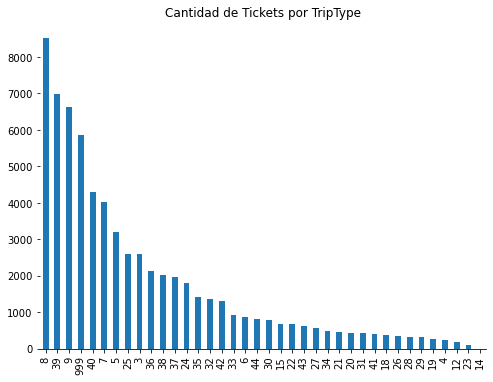

In [13]:
# 9) Agrupamos por VisitNumber para realizar un conteo de los valores de la variable TripType 
plt.figure (figsize=(8,6))
plt.title('Cantidad de Tickets por TripType')
sns.despine(left=True)
original_df.groupby("VisitNumber").TripType.mean().value_counts().plot(kind='bar')

* **Observación:** Los datos se encuentran desbalanceados con respecto a la cantidad de registros por TripType

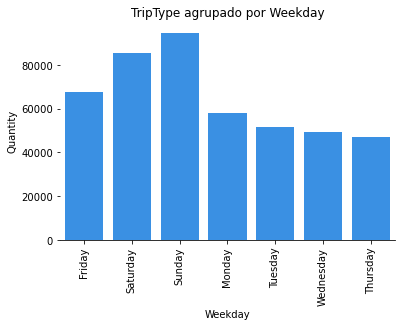

In [14]:
# 10) Graficamos TripType agrupado por Weekday
plt.figure (figsize=(6,4))
plt.title('TripType agrupado por Weekday')
sns.countplot(data=original_df, x='Weekday', color='dodgerblue')
plt.xticks(rotation=90)
plt.ylabel('Quantity')
sns.despine(left=True)

## 1.2 Verificacion de Valores Nulos

In [15]:
# 1) Obtenemos el número de valores faltantes por columna(variables) 
missing_values_count = original_df.isnull().sum()
missing_values_count[missing_values_count > 0]   

Upc                      2852
DepartmentDescription     972
FinelineNumber           2852
dtype: int64

In [16]:
# 2) Chequeamos si los registros con valores nulos de DepartmentDescription, se corresponden con los de Upc y FinelineNumber
(original_df.DepartmentDescription.isnull().sum(),
 (original_df.DepartmentDescription.isnull() & original_df.Upc.isnull() & original_df.FinelineNumber.isnull()).sum()) # si es nan el departamento los otros dos atributos lo son

(972, 972)

In [17]:
# 3) Chequeamos si los registros con valores nulos de Upc, se corresponden con los de FinelineNumber
(original_df.Upc.isnull().sum(),
 original_df.FinelineNumber.isnull().sum(),
 (original_df.FinelineNumber.isnull() & original_df.Upc.isnull()).sum())

(2852, 2852, 2852)

In [18]:
# 4) Eliminamos los registros que tengan valores nulos para las 3 variables
df_notna = original_df[pd.notnull(original_df['DepartmentDescription'])]
print(df_notna.DepartmentDescription.isnull().sum())
print(df_notna.FinelineNumber.isnull().sum())
print(df_notna.Upc.isnull().sum())

0
1880
1880


In [19]:
print("Cantidad de Registros iniciales;", len(original_df))
print("Cantidad de registros removidos:", len(original_df) - len(df_notna))
print("Cantidad de Registros actuales:", len(df_notna))

Cantidad de Registros iniciales; 453411
Cantidad de registros removidos: 972
Cantidad de Registros actuales: 452439


In [20]:
# 5) Reemplazamos los NaN de la feature UPC por la moda ya que se trata de una variable numerica discreta
warnings.filterwarnings('ignore')
df_notna.Upc.mode()[0]

df_notna.fillna({'Upc': df_notna.Upc.mode()[0]}, inplace=True)
df_notna.Upc.isnull().sum()

0

In [21]:
# 6) Reemplazamos los NaN de la feature FinelineNumber por la moda ya que se trata de una variable numerica discreta
warnings.filterwarnings('ignore')
df_notna.FinelineNumber.mode()[0]

df_notna.fillna({'FinelineNumber': df_notna.FinelineNumber.mode()[0]}, inplace=True)
df_notna.FinelineNumber.isnull().sum()

0

**Observaciones:** 
* Tenemos tres variables con valores nulos (Upc, DepartmentDescription y FinelineNumber).
* La cantidad de nulos para las variables Upc y FinelineNumber es el mismo, y los registros se corresponden.
* Verificamos que cuando DepartmentDescription es NaN, las columnas Upc y FinelineNumber también lo son, por lo tanto removemos esos registros.
* Reemplazamos por la moda, los valores nulos de las variables Upc y FinelineNumber.

## 1.3 Verificacion y eliminacion de Outliers

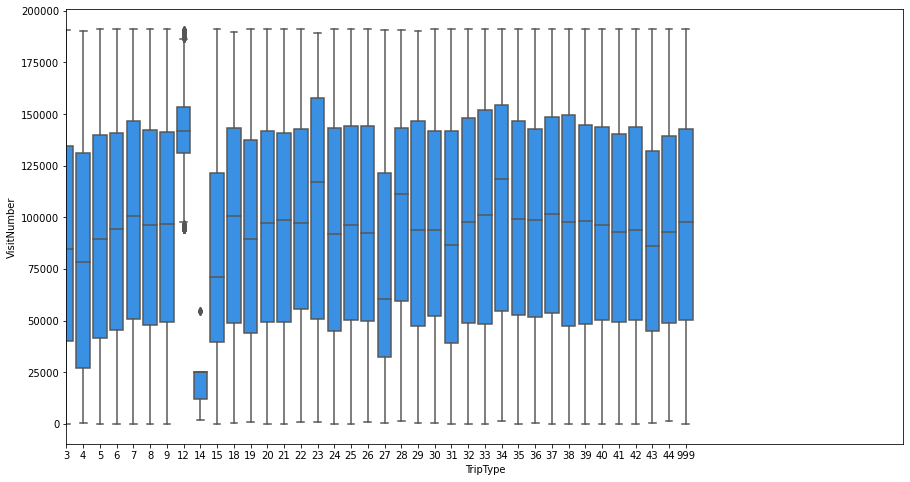

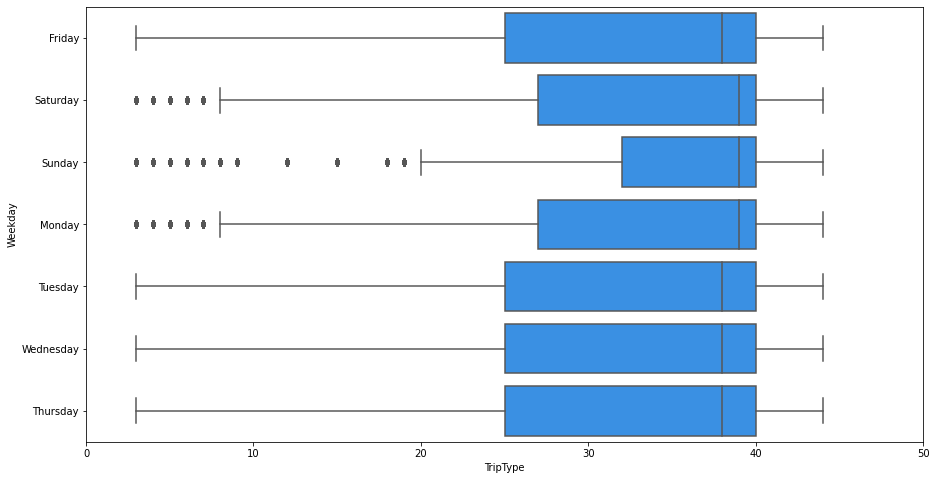

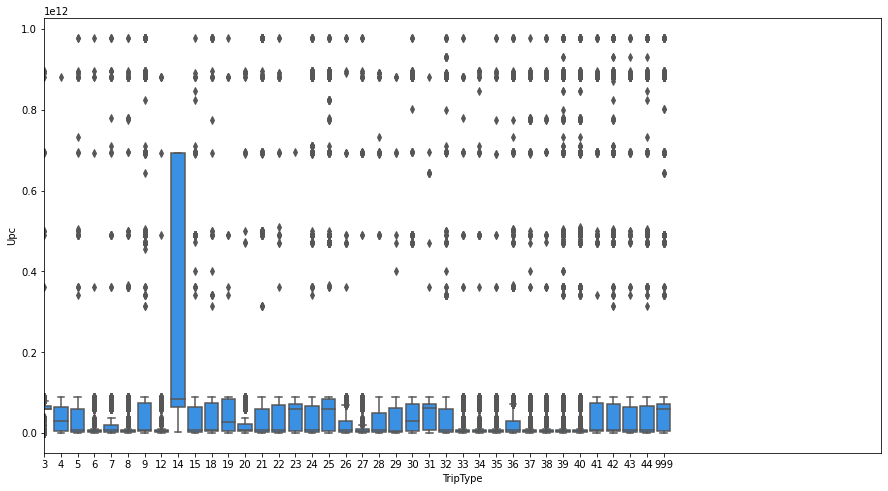

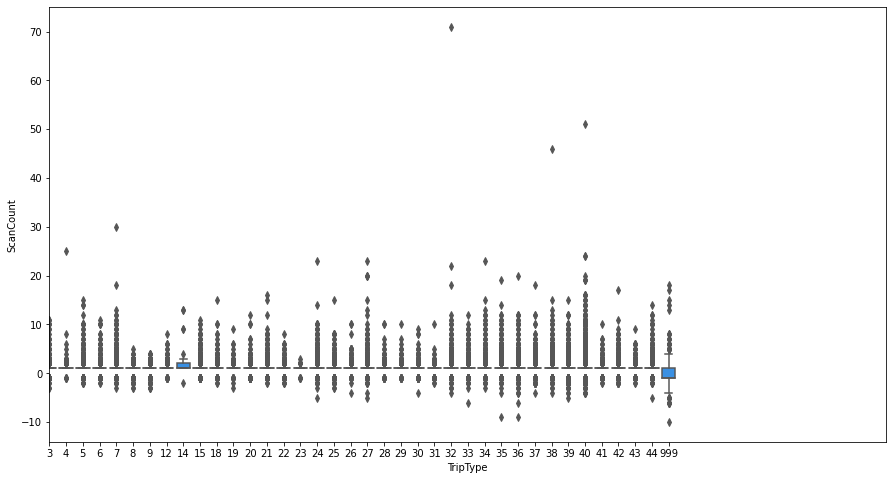

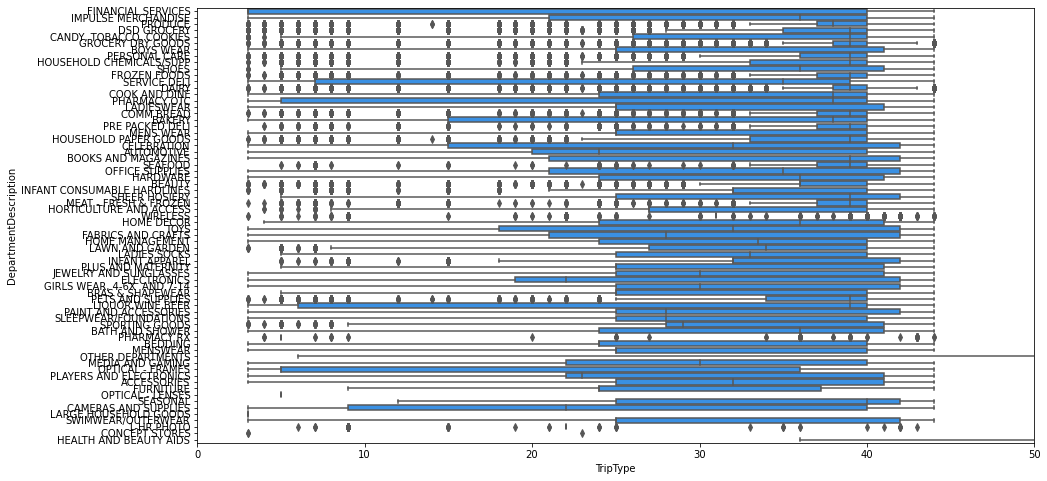

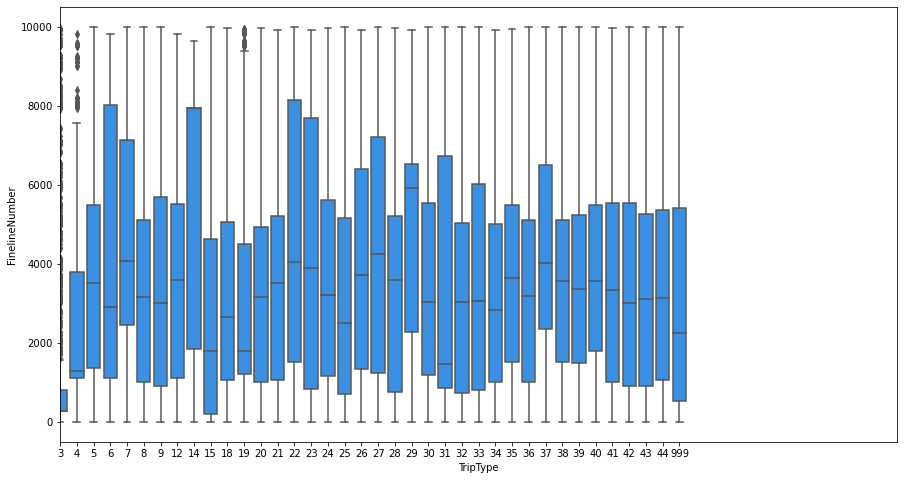

In [22]:
# 1) Graficamos los boxplot para detectar outliers
for feature in df_notna.columns:
    if feature != 'TripType':
        plt.figure (figsize=(15,8))
        sns.boxplot(data=df_notna, color='dodgerblue', x='TripType', y=feature)
        plt.xlim(0, 50)
        plt.ylabel(feature)
        plt.xlabel('TripType')
        plt.show()

**Observaciones:**
* Para la variable **VisitNumber** se detectan muy pocos outliers en los Triptype 12 y 14. Pero al ser una variable identificadora (id) no se considerarán como outliers esos valores.
* La variable **Upc** posee muhcos outliers para la mayoría de los diferentes Triptype. 
* La variable **FinelineNumber** que también es un código de clasificación, posee menos outliers que **Upc**.
* Podemos notar que para la variable **ScanCount** existen outliers para algunos Tipos de Viaje (TripType).
* La variable  **DepartmentDescription** posee muchas categorías con outliers.

In [23]:
# 2) Filtramos los outliers 
def clean_outliers(dataset, column_name):
    """Returns dataset removing the outlier rows from column @column_name."""
    interesting_col = dataset[column_name]
    mask_var_outlier = (
        np.abs(interesting_col - interesting_col.mean()) <= (15 * interesting_col.std()))
    return dataset[mask_var_outlier]

In [24]:
# 2.A) Filtramos los outliers de la variable ScanCount
df_clean_ScanCount = clean_outliers(df_notna, "ScanCount")
print("Filas removidas", len(df_notna) - len(df_clean_ScanCount))

Filas removidas 100


In [25]:
# 2.B) Redefiimos el nombre del dataset y calculamos el total de filas removidas hasta el momento
df_clean = df_clean_ScanCount
print("Cantidad de registros iniciales", len(original_df))
print("Total de registros filtrados", len(original_df) - len(df_clean))
print("Total de registros actuales", len(df_clean))

Cantidad de registros iniciales 453411
Total de registros filtrados 1072
Total de registros actuales 452339


Text(0.5, 0, 'TripType')

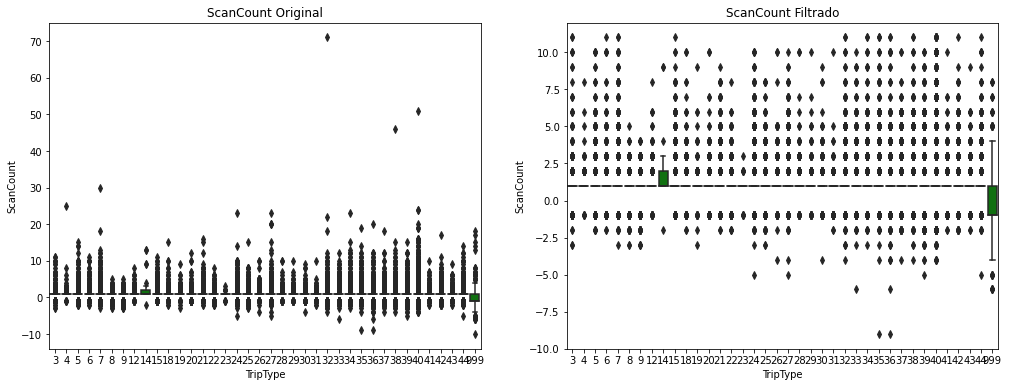

In [26]:
# 3) Graficamos los boxplot para corroborar la limpieza de los outliers de la variable ScanCount

plt.figure (figsize=(17,6))

plt.subplot(121)
plt1=sns.boxplot(data=original_df, color='green', x='TripType', y='ScanCount')
plt.title('ScanCount Original')
plt.ylabel('ScanCount')
plt.xlabel('TripType')

plt.subplot(122)
plt2=sns.boxplot(data=df_clean, color='green', x='TripType', y='ScanCount')
plt.title('ScanCount Filtrado')
plt.ylabel('ScanCount')
plt.xlabel('TripType')

In [27]:
# 4) Agrupamos los registros por VisitNumber
df_group = original_df.groupby(by='VisitNumber', as_index=False).agg({'Weekday': pd.Series.nunique})
print(df_group['Weekday'].unique())

[1]


In [28]:
df_group = original_df.groupby(by='VisitNumber', as_index=False).agg({'TripType': pd.Series.nunique})
print(df_group['TripType'].unique()) 

[1]


**Observaciones:**
* Al agrupar por **VisitNumber** y verificar los valores de Weekday notamos que todos los tickets son únicos para la variable Weekday
* Indica que Cada Visitante realizó una única compra en un mismo día.
* Al agrupar por **VisitNumber** y verificar los valores de TripType notamos tambien que todos los tickets son únicos para esta feature

## 1.4  Luego del análisis exploratorio, presentamos las consideraciones importantes que tomaremos en cuenta para la creación de la función que limpie y cargue el nuevo dataset:
* **1)** Usaremos **One hot encoding** para las variables **Weekday** y **DepartmentDescription**. Todas las transformaciones son aplicadas a los sets de Train y Test.
* **2)** No filtraremos los valores nulos de **DepartmentDescription**.
* **3)** Reemplazamos los valores nulos de la variable **Upc**  y **FinelineNumber** por la moda, ya que se trata de variables numéricas discretas.
* **4)** Es posible que tengamos varios registros para una sola visita (VisitNumber) y el objetivo es clasificar todos esos registros exactamente de la misma manera. Por tanto, prepararemos los datos de forma que toda la información de una visita quede en el mismo registro.
* **5)** Agrupamos por la variable **VisitNumber**
* **6)** Para probar los distintos modelos tomaremos la mitad del dataset en forma aleatoria.

In [29]:
def transform_data(train_data_fname, test_data_fname):
    # Cargamos el dataset de Entrenamiento
    df_train = pd.read_csv(train_data_fname) 
    df_train['is_train_set'] = 1
    
    # Cargamos el dataset de Evaluación
    df_test = pd.read_csv(test_data_fname) 
    df_test['is_train_set'] = 0
   
    # En el set de Entrenamiento
    # Agrupamos el dataset por VisitNumber y obtenemos el máximo
    y = df_train.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType

    # Removemos la variable TripType
    # Unificamos los conjuntos de datos (train y test)
    # Utilizamos la función concat para mantener el mismo índice de los registros
    df_train = df_train.drop("TripType", axis=1)
    df = pd.concat([df_train, df_test])
    
    # Reemplazamos los valores nulos de Upc y Finelinenumber
    df.fillna({'Upc': original_df.Upc.mode()[0]}, inplace=True)
    df.fillna({'FinelineNumber': original_df.FinelineNumber.mode()[0]}, inplace=True)

    # Aplicamos one-hot encoding para la variable DepartmentDescription sin valores nulos
    df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)

    # Agrupamos por visitNumber
    df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()
    
    # Aplicamos one-hot encoding par la variable Weekday
    df = pd.get_dummies(df, columns=["Weekday"], dummy_na=True)

    # Obtenemos los sets de Entrenamiento y Evaluación
    df_train = df[df.is_train_set != 0]
    df_test = df[df.is_train_set == 0]
    
    X = df_train.drop(["is_train_set"], axis=1)
    yy = None
    XX = df_test.drop(["is_train_set"], axis=1)

    return X, y, XX, yy

In [30]:
# Cargamos la información del dataset
X, y, XX, yy = transform_data("../data/train.csv", "../data/test.csv")

In [31]:
X.shape, y.shape, XX.shape

((67029, 81), (67029,), (28645, 81))

### 2. Prueba de diferentes modelos para seleccionar cual ajusta mejor a nuestros datos

**DESBALANCEO DE DATOS**
Podemos optar por alguno de estos dos metodos para balancearlos

*Ajuste de Parámetros del modelo*: Consiste en ajustar parametros ó metricas del propio algoritmo para intentar equilibrar a la clase minoritaria penalizando a la clase mayoritaria durante el entrenamiento. Ejemplos on ajuste de peso en árboles, también en logisticregression tenemos el parámetro class_weight= “balanced” que utilizaremos en este ejemplo. No todos los algoritmos tienen estas posibilidades. En redes neuronales por ejemplo podríamos ajustar la métrica de Loss para que penalice a las clases mayoritarias.

*Balanced Ensemble Methods*: Utiliza las ventajas de hacer ensamble de métodos, es decir, entrenar diversos modelos y entre todos obtener el resultado final (por ejemplo “votando”) pero se asegura de tomar muestras de entrenamiento equilibradas.

# Creación y Evaluación del modelo
### Los mejores modelos ya fueron presentados cada uno en su respectiva notebook.
### En este caso presentaremos otros modelos probados, pero que no superaron el Accuracy obtenido con Random Forest en las noteboks 4, 7 y 8.

#### 2.1. Selección del Modelo: **Decision Tree**

In [32]:
# Divisiòn del dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

In [33]:
res_acc_df = pd.DataFrame(columns=('description', 'clf', 'best_acc'))

In [34]:
# Seteo de Hiperparametros
tree_param = {
              'criterion':('gini', 'entropy'), 
              'min_samples_leaf':(1, 2, 5),
              'min_samples_split':(2, 3, 5, 10, 50, 100),
              'random_state':(0, 1, 2, 42)
             }

model_tree = DT()

tree_clf = GridSearchCV(model_tree, tree_param, cv=3, scoring='accuracy') #scoring='balanced_accuracy')

In [35]:
# Entrenamiento del modelo
tree_clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'min_samples_leaf': (1, 2, 5),
                         'min_samples_split': (2, 3, 5, 10, 50, 100),
                         'random_state': (0, 1, 2, 42)},
             scoring='accuracy')

In [36]:
# El dataframe results será utilizado para almacenar los resultaados computados
results = tree_clf.cv_results_
    
df = pd.DataFrame(results)
df_result = df[['param_criterion', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']]
df_result

,param_criterion,param_min_samples_leaf,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
0,gini,1,2,0.593372,0.001646,81
1,gini,1,2,0.593265,0.001979,82
2,gini,1,2,0.592903,0.001494,83
3,gini,1,2,0.592711,0.001318,84
4,gini,1,3,0.593691,0.001855,78
...,...,...,...,...,...,...
139,entropy,5,50,0.618564,0.002485,36
140,entropy,5,100,0.617519,0.002252,41
141,entropy,5,100,0.617519,0.002252,41
142,entropy,5,100,0.617519,0.002252,41


In [37]:
# Seleccionamos el modelo con mean_test_score mas alto y menor varianza
df_bm = df_result[df_result['rank_test_score'] == 1]
df_bm

,param_criterion,param_min_samples_leaf,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
71,gini,5,100,0.638683,0.005303,1


In [38]:
best_tree_clf = tree_clf.best_estimator_
bestpar = tree_clf.best_params_

print('Mejor Modelo\n', best_tree_clf)
print('Mejores Parametros\n', bestpar)

Mejor Modelo
 DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=100,
                       random_state=42)
Mejores Parametros
 {'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 100, 'random_state': 42}


In [39]:
print('Best Decision Tree accuracy: ', tree_clf.best_score_)
res_acc_df = res_acc_df.append({'description': 'modelo dt first run', 'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)

Best Decision Tree accuracy:  0.6386828644501279


In [40]:
res_acc_df

,description,clf,best_acc
0,modelo dt first run,"DecisionTreeClassifier(min_samples_leaf=5, min...",0.638683


#### 2.2. Selección del Modelo: **Naive Bayes**

In [41]:
# Dividimos el set de datos en Entrenamiento y Test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=0)

In [42]:
X_train.ScanCount[X_train.ScanCount < 0 ] = 0

In [43]:
modelNB = MultinomialNB().fit(X_train, y_train)

In [44]:
X_train.shape, y_train.shape

((40217, 81), (40217,))

In [45]:
y_train_pred=modelNB.predict(X_train)

In [46]:
acc_score = accuracy_score(y_train, y_train_pred)

print('Naive Bayes accuracy: ', acc_score)
res_acc_df = res_acc_df.append({'description': 'modelo nv second run', 'clf': 'default', 'best_acc': acc_score}, ignore_index=True)

Naive Bayes accuracy:  0.16162319417161897


In [47]:
res_acc_df

,description,clf,best_acc
0,modelo dt first run,"DecisionTreeClassifier(min_samples_leaf=5, min...",0.638683
1,modelo nv second run,default,0.161623


#### 2.3. Selección del Modelo: **Random Forest**

In [48]:
# Seteo de hiperparámetos
rf_param = {
              'criterion':('gini', 'entropy'), 
              'min_samples_leaf':(1, 2, 5),
              'min_samples_split':(2, 3, 5, 10, 50, 100),
              'random_state': [0,1,2],
              'n_estimators': [50,75,100],
              'class_weight' : ('balanced', 'balanced_subsample')
            }

model_rf = RandomForestClassifier()
rf_clf = GridSearchCV(model_rf, rf_param, cv=3, scoring='accuracy') #scoring='balanced_accuracy')

In [49]:
rf_clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ('balanced', 'balanced_subsample'),
                         'criterion': ('gini', 'entropy'),
                         'min_samples_leaf': (1, 2, 5),
                         'min_samples_split': (2, 3, 5, 10, 50, 100),
                         'n_estimators': [50, 75, 100],
                         'random_state': [0, 1, 2]},
             scoring='accuracy')

In [50]:
# El dataframe results será utilizado para almacenar los resultaados computados
results = rf_clf.cv_results_
    
df = pd.DataFrame(results)
df_result = df[['param_criterion', 'param_min_samples_leaf', 'param_min_samples_split', 'param_random_state', 'param_n_estimators', 'param_class_weight', 'mean_test_score', 'std_test_score', 'rank_test_score']]
df_result

,param_criterion,param_min_samples_leaf,param_min_samples_split,param_random_state,param_n_estimators,param_class_weight,mean_test_score,std_test_score,rank_test_score
0,gini,1,2,0,50,balanced,0.685556,0.001944,24
1,gini,1,2,1,50,balanced,0.682348,0.000935,36
2,gini,1,2,2,50,balanced,0.683542,0.001802,31
3,gini,1,2,0,75,balanced,0.687197,0.001613,13
4,gini,1,2,1,75,balanced,0.686600,0.001306,19
...,...,...,...,...,...,...,...,...,...
643,entropy,5,100,1,75,balanced_subsample,0.540916,0.004401,644
644,entropy,5,100,2,75,balanced_subsample,0.544123,0.005413,632
645,entropy,5,100,0,100,balanced_subsample,0.542756,0.001710,638
646,entropy,5,100,1,100,balanced_subsample,0.540742,0.003926,645


In [51]:
# Seleccionamos el modelo con mean_test_score mas alto y menor varianza
df_bm = df_result[df_result['rank_test_score'] == 1]
df_bm

,param_criterion,param_min_samples_leaf,param_min_samples_split,param_random_state,param_n_estimators,param_class_weight,mean_test_score,std_test_score,rank_test_score
340,gini,1,3,1,100,balanced_subsample,0.688788,0.001343,1


In [52]:
best_rf_clf = rf_clf.best_estimator_
bestpar = rf_clf.best_params_

print('Mejor Modelo\n', best_rf_clf)
print('Mejores Parametros\n', bestpar)

Mejor Modelo
 RandomForestClassifier(class_weight='balanced_subsample', min_samples_split=3,
                       random_state=1)
Mejores Parametros
 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100, 'random_state': 1}


In [53]:
print('Best Regression Logistic accuracy: ', rf_clf.best_score_)
res_acc_df = res_acc_df.append({'description': 'modelo rf third run', 'clf': rf_clf, 'best_acc': rf_clf.best_score_}, ignore_index=True)

Best Regression Logistic accuracy:  0.6887883266707447


In [54]:
res_acc_df

,description,clf,best_acc
0,modelo dt first run,"DecisionTreeClassifier(min_samples_leaf=5, min...",0.638683
1,modelo nv second run,default,0.161623
2,modelo rf third run,"GridSearchCV(cv=3, estimator=RandomForestClass...",0.688788


#### 2.4. Selección del Modelo: **Boosting with xgboost**

In [56]:
from xgboost import XGBRegressor
import xgboost as xgb

In [57]:
# Seteo de Hipeparámetros
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

In [58]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, colsample_bytree=0.3, max_depth=5, n_estimators=10,
             objective='reg:squarederror')

In [59]:
y_train_pred = xg_reg.predict(X_train)

In [60]:
mse = mean_squared_error(y_train, y_train_pred)
print("MSE: %f" % (mse))

MSE: 53676.925467


In [61]:
y_valid_pred = xg_reg.predict(X_valid)

In [62]:
y_valid.shape, y_valid_pred.shape

((26812,), (26812,))

In [63]:
pred=[round(value) for value in y_valid_pred]

In [64]:
acc_score = accuracy_score(y_valid, pred)

In [65]:
print('Boosting accuracy: ', acc_score)
res_acc_df = res_acc_df.append({'description': 'modelo boosting fourth run', 'objective =reg:squarederror, colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10': 'default', 'best_acc': acc_score}, ignore_index=True)

Boosting accuracy:  0.007981500820528122


In [66]:
res_acc_df

,description,clf,best_acc,"objective =reg:squarederror, colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10"
0,modelo dt first run,"DecisionTreeClassifier(min_samples_leaf=5, min...",0.638683,NaN
1,modelo nv second run,default,0.161623,NaN
2,modelo rf third run,"GridSearchCV(cv=3, estimator=RandomForestClass...",0.688788,NaN
3,modelo boosting fourth run,NaN,0.007982,default


In [67]:
X.shape, XX.shape

((67029, 81), (28645, 81))

#### 2.4. Selección del Modelo: **Ensemble with DT**

In [69]:
from imblearn.ensemble import BalancedBaggingClassifier

In [70]:
# Seteo de hipeparámetros
bbc = BalancedBaggingClassifier(base_estimator=DT(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

In [71]:
# Entrenamos el clasificador
bbc.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                          random_state=0)

In [72]:
y_valid_pred = bbc.predict(X_valid)

In [73]:
y_valid.shape, y_valid_pred.shape

((26812,), (26812,))

In [74]:
pred=[round(value) for value in y_valid_pred]

In [75]:
acc_score = accuracy_score(y_valid, pred)

In [76]:
acc_score 

0.3421602267641355